# Homework 3

Your name: Mohammad Manzoor Hassan Mirza

Your Andrew ID: mmmirza

Collaborators (if none, say \"none\"; do *not* leave this blank): none

# Part 1: Email spam classification [50 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

In [49]:
# # extracting zip file to ./email-data

# import zipfile as zf
# files = zf.ZipFile("./preprocessed-enron-email-dataset.zip", 'r')
# files.extractall("./email-data")
# files.close()

# # deteled MACOSX folder
# import shutil
# shutil.rmtree('./email-data/__MACOSX', ignore_errors=True)

### (a) Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model? 
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [1]:
# import required module
import os

# creating path to access the main folder containing data sub-folders
path = './email-data/'

# iterate over two sub-folders in this path
for folder in ["spam", "ham"]:
    # join original path to access each sub-folder 
    path_folder = os.path.join(path, folder)
    # get the list of the entries in this specific sub-folder
    print("Number of", str(folder), "files:", len(os.listdir(path_folder)))

Number of spam files: 3671
Number of ham files: 1500


1. Yes, the dataset is imbalanced since the number of spam training points is 3,671 whereas the number of ham training points is 1,500. This can possibly lead to problems in training the model such as lower model accuracy or overfitting.

2. There are several ways to address the problem of an imbalanced sample. We could try oversampling i.e. randomly adding more examples to the minority class (ham files) or undersampling i.e. randomly removing examples from the majority class (spam files). 

### (b) Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
# creating path to access the main folder containing data sub-folders
path = './email-data/'

# an empty list to store a list of strings where each string is a processed email
docs = []
# an empty list to store the labels for each email i.e. 1 for spam and 0 for ham
docs_labels = []

# iterating through each sub-folder, one at a time
for sub_folder in ["spam", "ham"]:
    # join original path to access each sub-folder 
    path_folder = os.path.join(path, sub_folder)
    # loop through the files in each sub-folder
    for filename in os.listdir(path_folder):
        # create a path to access each file in the sub-folder
        path_folder_file = os.path.join(path_folder, filename)
        # open and read each file as text, and do some pre-processing to return one string i.e. a bunch of tokens
        docs.append(makeWordList(path_folder_file))
        # concomitantly add respective labels, each time a file from spam/ ham sub-folder is being read
        if sub_folder == "spam":
            docs_labels.append(1)
        if sub_folder == "ham":
            docs_labels.append(0)

### (c) Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [4]:
# CountVectorizer does tokenization, removes terms that occur too frequently, not frequently enough or are stop words
from sklearn.feature_extraction.text import CountVectorizer

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.8, # remove words that appear in more than 80% of the documents, since they are not interesting
                                min_df=50, # remove any words that appear in less than 50 documents
                                stop_words='english')

# transform gives you a feature vector representation (typically requires a list of strings such as 'docs' as input)
# In X, documents/emails are rows, words are columns, cell values are the raw term frequency counts
X = tf_vectorizer.fit_transform(docs)
# converting the matrix to a numpy array
X = X.toarray()

# printing the number of unique words 
vocab = list(tf_vectorizer.vocabulary_.keys())
print(len(vocab))

1680


### (d) k-NN and random forest: Hyperparameter selection [15 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [5]:
# Task 1 (KNN): choosing hyperparameter k which give the highest CV score (code comments added in the next part)

from sklearn.model_selection import KFold
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

num_folds = 5
k_fold = KFold(num_folds)
best_k = None
best_cross_val_score = -np.inf  

for k in 2**np.arange(0, 8):
    fold_scores = []    
    
    for proper_train_indices, val_indices in k_fold.split(X):
        proper_train_features = X[proper_train_indices]
        proper_train_labels = np.array(docs_labels)[proper_train_indices]
        val_features = X[val_indices]
        val_labels = np.array(docs_labels)[val_indices]

        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = knn_classifier.predict(val_features)
        fold_score = f1_score(val_labels, predicted_val_labels, average='weighted')
        fold_scores.append(fold_score)    

    cross_val_score = np.mean(fold_scores)
    print('k:', k, 'cross validation score:', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better 
        best_cross_val_score = cross_val_score
        best_k = k

print('Best k:', best_k, 'highest cross validation score:', best_cross_val_score)

k: 1 cross validation score: 0.9255955639970417
k: 2 cross validation score: 0.9268892583530188
k: 4 cross validation score: 0.9128137740182047
k: 8 cross validation score: 0.8928154389747494
k: 16 cross validation score: 0.8676940432911854
k: 32 cross validation score: 0.842165487503177
k: 64 cross validation score: 0.8204890460395061
k: 128 cross validation score: 0.802796314851802
Best k: 2 highest cross validation score: 0.9268892583530188


In [6]:
# Task 2 (Random Forests): choosing hyperparameters (max_features, min_samples_leaf) which give the highest CV score

from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# each fold is used ONCE as the 'validation' set, while the other four folds form the 'proper training set'
num_folds = 5

# Kfold keeps a track of indices of what items are in training and validation set 
k_fold = KFold(num_folds)

# nonetype variables to store the best hyperparameters max_features and min_samples_leaf
best_max_features = None
best_min_samples_leaf = None

# assumes that a higher score is better (use np.inf, if using misclassification error instead since lower error is better)
best_cross_val_score = -np.inf

# only used to set up the grid for max_features (usually RF yeilds max features as sq.root(num_features))
num_features = X.shape[1]

# a list of tuples with different hyperparameter combinations
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]  

# looping through each tuple of (max_features, min_samples_leaf) in the list hyperparameter_settings
for max_features, min_samples_leaf in hyperparameter_settings:
    # for each hyperamarameter setting, storing five f1_scores in this list (to compute the average at a later stage)
    fold_scores = []
    
    # split the data into two sets of indicies i.e. "proper training" and validation, using k_fold.split
    for proper_train_indices, val_indices in k_fold.split(X):
        # using the indices generated by split above to create a subset from training data -> proper training features 
        proper_train_features = X[proper_train_indices]
        # using the indices generated by split above to to create a subset from training labels -> proper training labels 
        proper_train_labels = np.array(docs_labels)[proper_train_indices]
        # using the indices generated by split above to to create a subset from training data -> validation features
        val_features = X[val_indices]
        # using the indices generated by split above to create a subset from training labels -> validation labels
        val_labels = np.array(docs_labels)[val_indices]

        # plugging in the current iteration of hyperparameter setting to Random Forest Classifier
        rf_classifier = RandomForestClassifier(max_features=max_features,
                                               min_samples_leaf=min_samples_leaf,
                                               random_state=0)
        # fit the model on the proper training set -> the model will be fit k i.e. five times
        rf_classifier.fit(proper_train_features, proper_train_labels)
        # predicting labels in the validation set -> this process is also repeated k i.e. five times
        predicted_val_labels = rf_classifier.predict(val_features)
        # calculating the f1 score on the validation set
        fold_score = f1_score(val_labels, predicted_val_labels, average='weighted')
        fold_scores.append(fold_score)
    # ****once this INNER for loop completes, five scores would have been appended to the empty list i.e. fold_scores****

    # for each hyperparameter setting (OUTER for loop), calculate the average across all five scores (from INNER for loop)
    cross_val_score = np.mean(fold_scores)
    print('max_features:', max_features, 'min_samples_leaf:', min_samples_leaf, 'cross validation score:', cross_val_score)
    # if this average > than the already saved best cv score, update the best cv score, along with the parameters
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better 
        best_cross_val_score = cross_val_score
        best_max_features = max_features
        best_min_samples_leaf = min_samples_leaf

# printing the hyperamater setting which gives the highest cross validation score i.e. average across all five folds
print('best_max_features:', best_max_features, 
      'best_min_samples_leaf:', best_min_samples_leaf,
      'highest cross validation score:', best_cross_val_score)

max_features: 11 min_samples_leaf: 1 cross validation score: 0.9709195384117212
max_features: 11 min_samples_leaf: 2 cross validation score: 0.9528399563328028
max_features: 11 min_samples_leaf: 4 cross validation score: 0.9292216541208511
max_features: 11 min_samples_leaf: 8 cross validation score: 0.8982626593647518
max_features: 11 min_samples_leaf: 16 cross validation score: 0.864457670500385
max_features: 41 min_samples_leaf: 1 cross validation score: 0.974494613316297
max_features: 41 min_samples_leaf: 2 cross validation score: 0.972057778645423
max_features: 41 min_samples_leaf: 4 cross validation score: 0.9662835907992365
max_features: 41 min_samples_leaf: 8 cross validation score: 0.9423243910365654
max_features: 41 min_samples_leaf: 16 cross validation score: 0.9152009051323591
max_features: 164 min_samples_leaf: 1 cross validation score: 0.9658728470427652
max_features: 164 min_samples_leaf: 2 cross validation score: 0.9669929766870068
max_features: 164 min_samples_leaf: 4 c

### (e) Classifier testing: Precision-Recall and ROC curves [25 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

**Answer:**  To ensure that the document matrix generated from training emails (ham/spam folders) and the one generated from testing emails (testing folder) has the same number of features i.e. 1,680 words, I used 'tf_vectorizer.transform' on the list of strings, docs_test. This provides us a feature vector representation for each email, and the matrix overall has dimensions (100, 1680) i.e. (test points, features/words).

Things to answer (responses provided at the end of the notebook):

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [7]:
# setting the knn_classifier using the best hyperparameter from previous part
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# fitting the rf_classifer on complete training data
final_knn_classifier.fit(X, np.array(docs_labels))

KNeighborsClassifier(n_neighbors=2)

In [8]:
# setting the rf_classifier using the best hyperparameters from previous part
final_rf_classifier = RandomForestClassifier(max_features=best_max_features, 
                                       min_samples_leaf=best_min_samples_leaf, 
                                       random_state=0)

# fitting the rf_classifer on complete training data
final_rf_classifier.fit(X, np.array(docs_labels))

RandomForestClassifier(max_features=41, random_state=0)

In [10]:
# storing the processed emails and their labels in testing in this empty list
docs_test = []
docs_test_labels = []

# reading in all files in the sub-folder 'testing'
path_folder = os.path.join(path, 'testing')
for filename in os.listdir(path_folder):
    path_folder_file = os.path.join(path_folder, filename)
    docs_test.append(makeWordList(path_folder_file))
    label = filename.split(".")[3]
    if label == 'spam':
        docs_test_labels.append(1)
    if label == 'ham':
        docs_test_labels.append(0)

# getting a feature vector representation (must have the same # of features i.e. 1680 words as in training data)
X_TEST = tf_vectorizer.transform(docs_test)
X_TEST = X_TEST.toarray()

In [11]:
# Using final knn_classifier to predict labels in the test dataset
predicted_test_labels_knn = final_knn_classifier.predict(X_TEST)

# calculating the proportion of misclassified labels i.e. test error rate
test_set_error_knn = np.mean(predicted_test_labels_knn != docs_test_labels)

# calculating the f1 score on test data
test_set_f1_knn = f1_score(docs_test_labels, predicted_test_labels_knn, average='weighted')

# printing test error rate from KNN classifier 
print("Test Error Rate (KNN):", test_set_error_knn, "\nF1 Score (KNN):", test_set_f1_knn)

Test Error Rate (KNN): 0.25 
F1 Score (KNN): 0.7373679255152211


In [12]:
# Using final rf_classifier to predict labels in the test dataset
predicted_test_labels_rf = final_rf_classifier.predict(X_TEST)

# calculating the proportion of misclassified labels i.e. test error rate
test_set_error_rf = np.mean(predicted_test_labels_rf != docs_test_labels)

# calculating the f1 score on test data
test_set_f1_rf = f1_score(docs_test_labels, predicted_test_labels_rf, average='weighted')

# printing test error rate and f1 score from RF classifier
print("Test Error Rate (RF):", test_set_error_rf, "\nF1 Score (RF):", test_set_f1_rf)

Test Error Rate (RF): 0.1 
F1 Score (RF): 0.8997596153846152


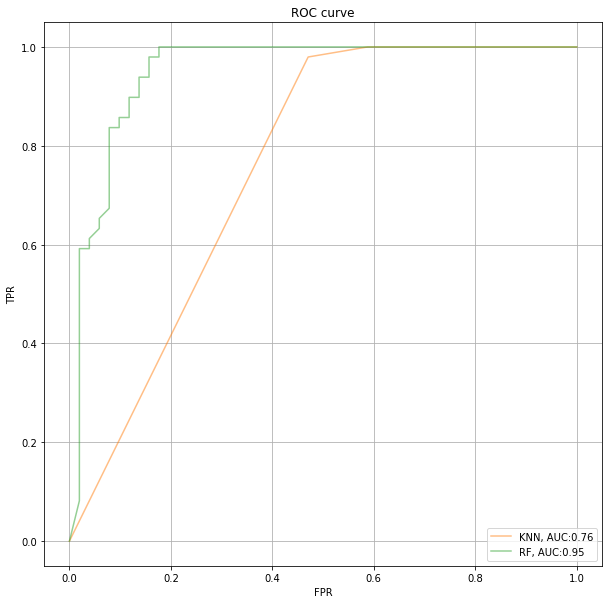

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

#set up plotting area
plt.figure(figsize=(10,10))

# plotting ROC curve for KNN
y_score = final_knn_classifier.predict_proba(X_TEST)[:, 1]
fpr, tpr, thresholds = roc_curve(docs_test_labels, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= 'C1', label="KNN, AUC:" + str(round (auc, 2)))

# plotting ROC curve for Random Forests
y_score = final_rf_classifier.predict_proba(X_TEST)[:, 1]
fpr, tpr, thresholds = roc_curve(docs_test_labels, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= 'C2', label="RF, AUC:" + str(round(auc, 2)))

# adding details
plt.title("ROC curve")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show() 

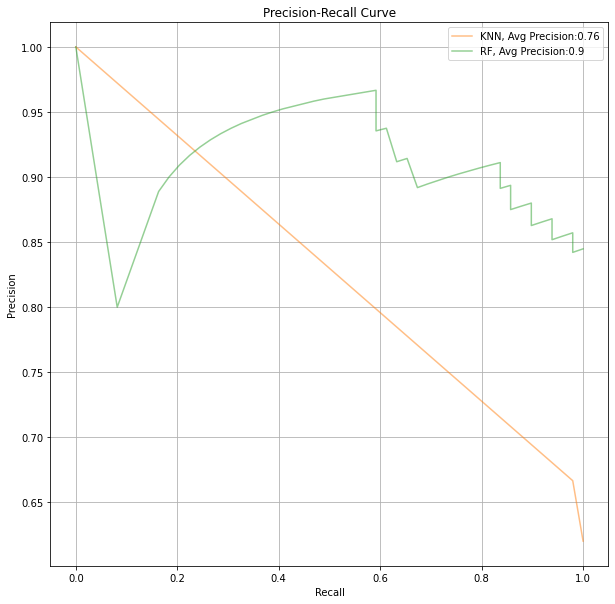

In [14]:
from sklearn.metrics import precision_recall_curve
import statistics as stat

#set up plotting area
plt.figure(figsize=(10,10))

# calculate precision, recall for KNN
y_score = final_knn_classifier.predict_proba(X_TEST)[:, 1]
precision, recall, thresholds = precision_recall_curve(docs_test_labels, y_score)
plt.plot(recall, precision, linestyle='-', alpha=0.5, color= 'C1', label="KNN, Avg Precision:" + 
         str(round(stat.mean(precision), 2)))

# calculate precision, recall for RF
y_score = final_rf_classifier.predict_proba(X_TEST)[:, 1]
precision, recall, thresholds = precision_recall_curve(docs_test_labels, y_score)
plt.plot(recall, precision, linestyle='-', alpha=0.5, color= 'C2', label="RF, Avg Precision:" + 
         str(round(stat.mean(precision), 2)))

# adding details
plt.title('Precision-Recall Curve')
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show() 
         
# Reference: https://www.statology.org/precision-recall-curve-python/

1. Since the classes (spam and ham) are imbalanced, using the Precision-Recall curve would make sense here. Moreover, the cost of false positives i.e. misclassifying a ham email as spam and losing out on critical information is probably more damaging than false negatives i.e. having a few spam emails in inbox. Therefore, using Precision i.e. (TP/ TP + FP) as a metric of evaluation makes intuitive sense here.

2. Based on the ROC curve, Random Forests is a better classifier than KNN since it's AUC appears to be much higher, thereby indicating better ability to distinguish between the two classes. Similarly, based on the Precision-Recall curve, Random Forests still emerges as the better classifier since its average Precision is much higher.